In [5]:
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
from tqdm import tqdm

import pandas as pd, warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

short_term_columns = ['analysts_down', 'analysts_down_percent', 'analysts_up_percent',
       'authors_count', 'capm_alpha_60m', 'coefficient_of_variation_90d',
       'debt_eq', 'div_growth_category', 'div_safety_category',
       'dividends_estimate_fy1_analyst_down',
       'dividends_estimate_fy1_analyst_up',
       'dividends_estimate_fy2_analyst_down',
       'dividends_estimate_fy2_analyst_up',
       'dps_consensus_mean_percent_revisions_down_1_annual_period_fwd',
       'eps_ltg', 'last_price_vs_sma_100d', 'last_price_vs_sma_10d',
       'last_price_vs_sma_200d', 'last_price_vs_sma_50d', 'momentum_12m',
       'momentum_3m', 'momentum_6m', 'momentum_9m', 'pb_ratio',
       'price_return_1y', 'price_return_3m', 'price_return_6m',
       'price_return_9m', 'return_on_net_tangible_assets',
       'return_on_total_capital', 'Future_3-5Y_EPS_without_NRI_Growth_Rate',
       'moment_rank', '5-Day_RSI', '9-Day_RSI', '14-Day_RSI',
       '6-1_Month_Momentum_%', '12-1_Month_Momentum_%', 'ratios_rank',
       'Forward_PE_Ratio', 'EV-to-Forward-EBITDA',
       'Earnings_Yield__Greenblatt__%', 'Volume']

accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

def load_data():
	data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]
	sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)
	df_dict = {}
	for source in data_sources:
		dfs = []
		print(source)
		for path in tqdm(sources_dict[source]):
			new_df = wr.s3.read_parquet(path, boto3_session=session)
			new_df["date"] = path.split("/")[-1].split(".")[0]
			dfs.append(new_df)

		df_dict[source] = pd.concat(dfs, axis = 0)
	joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
	return joined_df

def load_pred_price(df, days_ahead=5, diff = True):
	all_dates = df.index.get_level_values(0).unique()
	adjusted_dates = all_dates[:-days_ahead]
	adjusted_df = df.loc[adjusted_dates]

	pred_dates = all_dates[days_ahead:]
	dfs = []
	for i, d in enumerate(tqdm(pred_dates)):
		path = s3_price_collection_path + d + ".parquet"
		new_df = wr.s3.read_parquet(path, boto3_session=session)

		s = df.loc[all_dates[i], "primary_price"]
		intersect_tickers = np.intersect1d(new_df["ticker"].values, s[~s.isna()].index.values)
		new_df = new_df[new_df["ticker"].isin(intersect_tickers)]
		new_df["date"] = all_dates[i]
		dfs.append(new_df)

	price_df = pd.concat(dfs, axis = 0).set_index(["date", "ticker"]).rename({"primary_price": "pred_price"}, axis = 1)

	if diff:
		a_df = adjusted_df.reindex(price_df.index)
		return a_df, pd.Series((price_df["pred_price"] - a_df["primary_price"]) / a_df["primary_price"], index=price_df.index)
	return adjusted_df.reindex(price_df.index), price_df

def split_date(all_dates, train_size = 0.75, days_ahead = 5):
	num_dates = len(all_dates)
	num_train_test_dates = num_dates - days_ahead
	num_train_dates = int(num_train_test_dates * train_size)

	train_dates = all_dates[:num_train_dates]
	val_dates = all_dates[num_train_dates:num_train_dates+days_ahead]
	test_dates = all_dates[num_train_dates+days_ahead:]

	return train_dates, val_dates, test_dates

def create_autoreg_features(df, short_term_features, num_days = 2):
	all_days = df.index.get_level_values(0).unique().sort_values()

	new_df = pd.DataFrame()
	for dayIndex in range(num_days, all_days.shape[0]):
		day = all_days[dayIndex]

		newDayDf = df.loc[day]
		newDayDf["date"] = day
		currTickers = newDayDf.index.values
		for prevIndex in range(num_days):
			prevDay = all_days[dayIndex - prevIndex]
			prevDayFeatures = df.loc[prevDay].reindex(currTickers)[short_term_features].add_suffix(f"_prev_{prevIndex + 1}")
			newDayDf = pd.concat([newDayDf, prevDayFeatures], axis = 1)
		
		new_df = pd.concat([new_df, newDayDf.set_index("date", append = True)], axis = 0)

	autoreg_removed_rows = df.loc[all_days[:num_days]].shape[0]

	assert df.shape[0] - new_df.shape[0] == autoreg_removed_rows, "Autoregression removed different amount of rows than expected"
	
	return new_df.reorder_levels([1, 0]).sort_index()

### Steps:

Load:

- Load data
- Create autoregressive features
- Load prediction price
- Split train/val/test dates
- Split into train/val/test dataset

Preprocess:

- One-hot encoder for features: sector, area
- Standard scaler for rest of features
	- ignore NaNs
- Fit on train set

In [6]:
# Load

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

df = load_data()
print(f"Loaded data shape: {df.shape}")
autoreg_df = df
# autoreg_df = create_autoreg_features(df, short_term_columns, num_days=2)
# print(f"Post autoregressive: {autoreg_df.shape}")
X_df, y_series = load_pred_price(autoreg_df, days_ahead = 5, diff = True)
print(f"Post loaded pred price: {X_df.shape, y_series.shape}")

train_dates, val_dates, test_dates = split_date(X_df.index.get_level_values(0).unique().sort_values())
print(f"# of train dates ({len(train_dates)}), val dates ({len(val_dates)}), test dates ({len(test_dates)})")

X_df = X_df.fillna({"sector": "none", "area": "none"})

X_train, y_train = X_df.loc[train_dates], y_series.loc[train_dates]
X_val, y_val = X_df.loc[val_dates], y_series.loc[val_dates]
X_test, y_test = X_df.loc[test_dates], y_series.loc[test_dates]

print(f"Train shapes: {X_train.shape, y_train.shape}")
print(f"Val shapes: {X_val.shape, y_val.shape}")
print(f"Test shapes: {X_test.shape, y_test.shape}")


seekingAlpha.seekingAlphaBulkMetrics


100%|██████████| 35/35 [00:33<00:00,  1.06it/s]


gurufocus


100%|██████████| 35/35 [00:23<00:00,  1.49it/s]


Loaded data shape: (55341, 339)


100%|██████████| 30/30 [00:13<00:00,  2.29it/s]

Post loaded pred price: ((47093, 339), (47093,))
# of train dates (18), val dates (5), test dates (7)
Train shapes: ((28240, 339), (28240,))
Val shapes: ((7729, 339), (7729,))
Test shapes: ((11124, 339), (11124,))


In [19]:
X_train.isna().sum()

altman_z_score                   6692
analysts_down                     516
analysts_down_percent             627
analysts_down_percent_avg_5y     3778
analysts_up                       516
                                ...  
Avg_Volume__2M_                  3132
Market_Cap                       3132
Enterprise_Value                 3132
FCF_Margin_%                    28240
FCF_Yield_%                     28240
Length: 339, dtype: int64

In [7]:
X_val[["sector", "area"]].isna().sum()

sector    0
area      0
dtype: int64

In [8]:
# Preprocess
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

onehot_features = ["sector", "area"]
standard_scale_features = [f for f in X_train.columns.values if f not in onehot_features]

preprocessor = ColumnTransformer(
	transformers = [
		("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), onehot_features),
		("std", StandardScaler(), standard_scale_features)
	]
)

In [10]:
# Assemble pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import PredefinedSplit, GridSearchCV

def XGBoost_RMSE(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, param_grid):
	# lists to be returned 
	test_scores = []
	best_models = []

	ps = PredefinedSplit([-1 for i in range(X_train.shape[0])] + [0 for i in range(X_val.shape[0])])

	X_other = pd.concat([X_train, X_val], axis = 0).reset_index(drop = True)
	y_other = pd.concat([y_train, y_val], axis = 0).reset_index(drop = True)

	# your code here...
	for state in range(5, 6):

			# print("Split shapes")
			# print(X_other.shape, X_test.shape)

			xgb_algo = XGBRegressor(random_state = state)

			pipe = make_pipeline(preprocessor, xgb_algo)

			grid = GridSearchCV(
					pipe, cv = ps, param_grid = param_grid, scoring = "neg_root_mean_squared_error",
					return_train_score = True, verbose = True)

			grid.fit(X_other, y_other)

			print(f"Best params for random state: {state}")
			print(grid.best_params_)

			y_pred = grid.best_estimator_.predict(X_test)

			rmse = mean_squared_error(y_test, y_pred, squared = False)

			print(f"RMSE for best estimator: {rmse:.2f}")

			test_scores.append(rmse)
			best_models.append(grid.best_estimator_)

	return test_scores, best_models

In [11]:
xgboost_param_grid = {
	# "xgbregressor__eta": TODO,
	"xgbregressor__n_estimators": [30, 100, 150],
	"xgbregressor__gamma": [0.1, 0.01, 0.001, 0.],
	'xgbregressor__learning_rate': [0.1, 0.01, 0.001],
	"xgbregressor__reg_lambda": [0.5, 1.0, 5.]
}

warnings.simplefilter("ignore")

grid_result = XGBoost_RMSE(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor, xgboost_param_grid)

Fitting 1 folds for each of 108 candidates, totalling 108 fits
Best params for random state: 5
{'xgbregressor__gamma': 0.01, 'xgbregressor__learning_rate': 0.001, 'xgbregressor__n_estimators': 150, 'xgbregressor__reg_lambda': 0.5}
RMSE for best estimator: 0.07


In [12]:
y_pred = grid_result[1][0].predict(X_test)

(array([1.000e+01, 1.900e+01, 7.000e+01, 9.800e+01, 4.909e+03, 5.757e+03,
        2.140e+02, 3.200e+01, 1.000e+01, 5.000e+00]),
 array([-0.0311757 , -0.02447274, -0.01776978, -0.01106681, -0.00436385,
         0.00233911,  0.00904208,  0.01574504,  0.022448  ,  0.02915097,
         0.03585393]),
 <BarContainer object of 10 artists>)

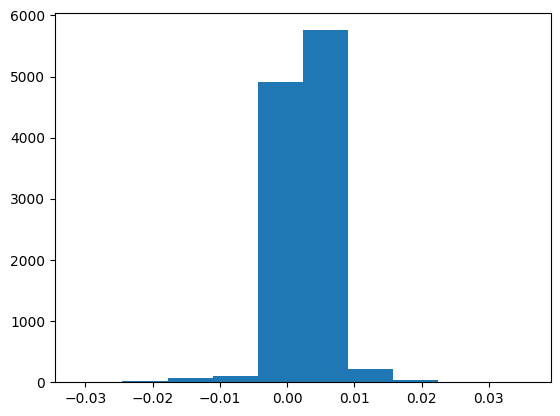

In [15]:
import matplotlib.pyplot as plt

plt.hist(y_pred)

(array([1.000e+00, 3.000e+00, 1.600e+01, 9.500e+01, 1.312e+03, 8.752e+03,
        8.550e+02, 7.700e+01, 8.000e+00, 5.000e+00]),
 array([-0.71222179, -0.57888648, -0.44555118, -0.31221587, -0.17888057,
        -0.04554526,  0.08779005,  0.22112535,  0.35446066,  0.48779596,
         0.62113127]),
 <BarContainer object of 10 artists>)

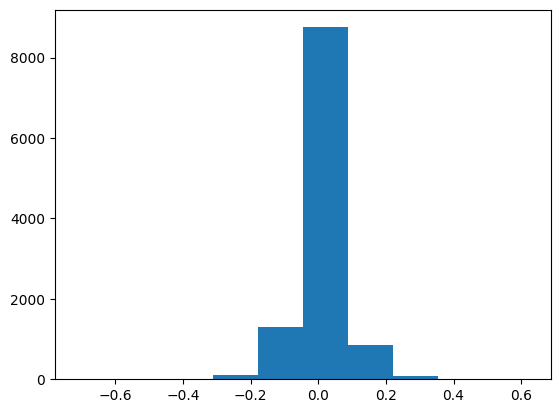

In [16]:
plt.hist(y_test)

In [13]:
mean_squared_error(y_test, y_pred, squared = False)

0.06821198865515292

In [101]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test > 0.0, y_pred > 0.0)

0.6240560949298813

In [78]:
y_test.shape[0]

9577

In [1]:
from xgboost.sklearn import XGBRegressor

In [2]:
reg = XGBRegressor()

In [3]:
reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [4]:
reg.n_estimators